# Introduction

This series of notebooks documents the analysis of microbiomes from various origins. The data were collected from 25 ponds, each belonging to one of five different experimental setups (see table below) that varied in probiotic supplementation.

For each pond, multiple samples were collected:

- Fish gut samples: Five samples from five individual fish.
- Sediment samples: Two samples per pond, collected at two different time points (refer to the sediment notebooks).
- Water samples: Three samples per pond, collected at three time points (refer to the H₂O notebooks).

  

| number | setup | pond numbers | water supplementation | feed suplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|



The 16S rRNA region of these samples was sequenced using the Illumina HiSeq 2000 platform. Subsequently, abundance tables for bacterial families, KEGG pathways, and KEGG orthologs were generated using the GGPicrust2 software.

The primary objectives of this analysis are to:

- Compare different approaches to classification analysis of the datasets.
- Develop an effective classification model capable of accurately distinguishing between experimental setups.

If you want to learn more [Here](https://theta.edu.pl/projects/cyprinus_carpio/) you can find describtion of the full project on our website.

# Libraries import and data loading  

If you want you can run this notebook in google colaboratory platfotm using [this link]() 


In [4]:
#libraries import
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import normalize , LabelEncoder
from sklearn.model_selection import train_test_split, KFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

from functions import *

np.random.seed(111)
tf.random.set_seed(111)

In [2]:
# load data from github 

df = pd.read_csv('https://raw.githubusercontent.com/paq88/Fish_neural_network_classifier/refs/heads/main/Gut_analysis/Data/Gut_bacteria_merged.csv')
print(f"shape:{df.shape}")
print(df.dtypes.value_counts())
df.head()

shape:(124, 127)
float64    126
object       1
Name: count, dtype: int64


,pond,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae,d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;o__Vicinamibacterales;f__uncultured,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae
0,Gut_S10,2319.0,2187.0,1743.0,500.0,521.0,286.0,366.0,612.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Gut_S10,3391.0,2071.0,355.0,1054.0,1024.0,1952.0,66.0,217.0,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Gut_S10,1338.0,7053.0,669.0,279.0,329.0,63.0,52.0,1338.0,139.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Gut_S10,1582.0,15595.0,124.0,503.0,309.0,5.0,3418.0,326.0,76.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gut_S10,1463.0,3891.0,541.0,7.0,13.0,11.0,61.0,398.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


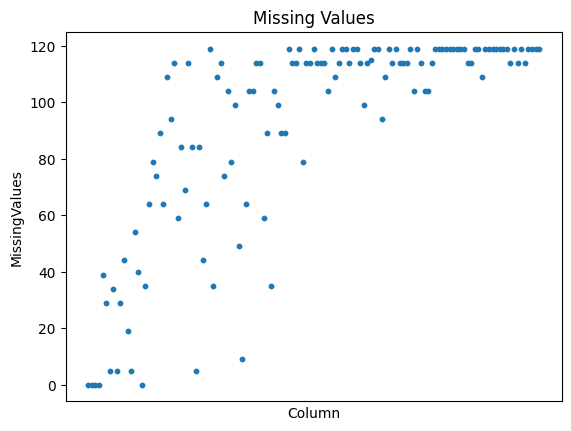

In [3]:


missing_values = df.isna().sum().reset_index()
missing_values.columns = ['Column', 'MissingValues']
ax = missing_values.plot(kind='scatter', x='Column', y='MissingValues', s=10)
ax.title.set_text('Missing Values')
ax.set_xticks([])
plt.show()

We can note that we have a lot of missing values in our dataset this says that samples taken from different ponds are having differrent bacteria famillies, fortunetaly as missing values means that no bacteria of given familly was found we can replace missing values with zeroes.

In [4]:
df = df.fillna(0)
df.head()

,pond,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae,d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;o__Vicinamibacterales;f__uncultured,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae
0,Gut_S10,2319.0,2187.0,1743.0,500.0,521.0,286.0,366.0,612.0,160.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Gut_S10,3391.0,2071.0,355.0,1054.0,1024.0,1952.0,66.0,217.0,95.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Gut_S10,1338.0,7053.0,669.0,279.0,329.0,63.0,52.0,1338.0,139.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Gut_S10,1582.0,15595.0,124.0,503.0,309.0,5.0,3418.0,326.0,76.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Gut_S10,1463.0,3891.0,541.0,7.0,13.0,11.0,61.0,398.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.describe()

,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae,d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;o__Vicinamibacterales;f__uncultured,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,...,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,831.653226,8693.169355,171.370968,71.137097,105.548387,196.209677,677.419355,375.854839,53.169355,25.241935,...,0.096774,0.298387,0.080645,2.153226,0.217742,1.604839,0.153226,0.096774,0.266129,0.185484
std,1120.105607,5604.123141,224.484829,146.755443,192.490201,637.902078,2845.964849,456.780652,98.483354,67.552253,...,1.077632,2.270274,0.898027,20.938565,2.093585,13.805159,1.706250,1.077632,2.537872,2.065461
min,0.000000,167.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,106.750000,3913.500000,37.750000,0.000000,0.000000,6.750000,0.000000,55.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,469.500000,7454.500000,105.500000,2.000000,13.500000,27.500000,0.000000,211.000000,4.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1037.750000,12774.000000,241.000000,91.500000,131.000000,118.250000,48.750000,467.250000,62.250000,15.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6597.000000,26160.000000,1743.000000,1054.000000,1024.000000,5020.000000,23193.000000,2505.000000,581.000000,539.000000,...,12.000000,23.000000,10.000000,232.000000,23.000000,144.000000,19.000000,12.000000,28.000000,23.000000


After seeing some basic statistics regarding columns we can see that range of valueus varries a lot we should normalise collumns (features).
We should also perform conversion of class variable to assign samples from different ponds to class used later for training of the model.

### Conversion of class variable


Explanation of pond coding

| number | setup | pond numbers | water supplementation | feed suplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

In [6]:
predictors = df.columns[1:]
print(f"Number of predictors: {len(predictors)}")

Number of predictors: 126


In [7]:
df.head()

,pond,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae,d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;o__Vicinamibacterales;f__uncultured,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae
0,Gut_S10,2319.0,2187.0,1743.0,500.0,521.0,286.0,366.0,612.0,160.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Gut_S10,3391.0,2071.0,355.0,1054.0,1024.0,1952.0,66.0,217.0,95.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Gut_S10,1338.0,7053.0,669.0,279.0,329.0,63.0,52.0,1338.0,139.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Gut_S10,1582.0,15595.0,124.0,503.0,309.0,5.0,3418.0,326.0,76.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Gut_S10,1463.0,3891.0,541.0,7.0,13.0,11.0,61.0,398.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# creating dataset splitted into 5 classes based on the pond 
codes = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}
codes3 = {0 : [8,14,18,24,29], 1: [12,16,19,23,26,9,13,17,20,27], 2 : [10,21,28,30,32,11,15,22,25,31]}
codes2 = {0 : [8,14,18,24,29,12,16,19,23,26,9,13,17,20,27], 1 : [10,21,28,30,32,11,15,22,25,31]}

df['pond_5'] = df['pond'].apply(lambda x: pond_decoder(x,codes))
df['pond_3'] = df['pond'].apply(lambda x: pond_decoder(x,codes3))
df['pond_2'] = df['pond'].apply(lambda x: pond_decoder(x,codes2))


In [9]:
df['pond_5'].value_counts()

pond_5
2    25
4    25
1    25
3    25
0    24
Name: count, dtype: int64

In [10]:
df[predictors]

,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae,d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;o__Vicinamibacterales;f__uncultured,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae
0,2319.0,2187.0,1743.0,500.0,521.0,286.0,366.0,612.0,160.0,144.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3391.0,2071.0,355.0,1054.0,1024.0,1952.0,66.0,217.0,95.0,287.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1338.0,7053.0,669.0,279.0,329.0,63.0,52.0,1338.0,139.0,95.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1582.0,15595.0,124.0,503.0,309.0,5.0,3418.0,326.0,76.0,105.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1463.0,3891.0,541.0,7.0,13.0,11.0,61.0,398.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,104.0,9862.0,107.0,20.0,8.0,83.0,3.0,92.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120,750.0,3483.0,422.0,381.0,245.0,119.0,8413.0,408.0,30.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121,183.0,1141.0,134.0,200.0,105.0,11.0,12974.0,124.0,45.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122,490.0,167.0,8.0,86.0,50.0,2.0,23193.0,66.0,16.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Applying CLR transformation

In [ ]:
def clr_manual(matrix):
    """Applies Centered Log-Ratio (CLR) transformation"""
    matrix = matrix + 1
    matrix = np.array(matrix)
    geometric_mean = np.exp(np.mean(np.log(matrix), axis=1))[:, np.newaxis] 
    clr_transformed = np.log(matrix / geometric_mean) 
    return clr_transformed
df[predictors] = pd.DataFrame(clr_manual(df[predictors]),columns = df[predictors].columns)

In [12]:
df.describe()

,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,...,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae,pond_5,pond_3,pond_2
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,...,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,5.184129,8.149255,3.644067,1.438091,1.940012,2.662686,1.427626,4.205627,1.532341,0.765683,...,-0.531471,-0.591769,-0.557780,-0.606219,-0.609693,-0.584653,-0.604748,2.016129,1.209677,0.403226
std,1.444798,1.072265,1.554761,2.158231,2.209887,1.951443,2.819811,1.903593,1.951759,1.643831,...,0.624163,0.391066,0.584453,0.373966,0.349500,0.417752,0.403019,1.414121,0.746528,0.492535
min,-0.325684,4.708501,-0.436293,-1.245936,-0.858576,-0.859457,-1.472139,-0.656742,-1.245936,-1.245936,...,-1.515104,-1.515104,-1.515104,-1.515104,-1.515104,-1.515104,-1.515104,0.000000,0.000000,0.000000
25%,4.245242,7.605297,3.165891,-0.408017,-0.366712,1.568823,-0.539976,3.359390,-0.374288,-0.452238,...,-0.746398,-0.756155,-0.756155,-0.764629,-0.764629,-0.756155,-0.770888,1.000000,1.000000,0.000000
50%,5.502807,8.190011,3.971892,0.400069,2.041522,2.687662,-0.279643,4.723931,1.130598,-0.307177,...,-0.545442,-0.557009,-0.557009,-0.576803,-0.576803,-0.545442,-0.582855,2.000000,1.000000,0.000000
75%,6.197913,9.010625,4.739503,3.659931,4.141260,4.021147,3.221774,5.387763,3.452128,2.208847,...,-0.389485,-0.399562,-0.399562,-0.401424,-0.401424,-0.395451,-0.401424,3.000000,2.000000,1.000000
max,7.913779,9.793854,6.362286,5.991671,5.983094,7.360192,9.636186,7.295474,5.159305,4.819431,...,4.517037,2.316767,3.730798,2.134445,1.703662,2.742058,2.591176,4.000000,2.000000,1.000000


Here we can see results of normalisation as each feature is getting values in the same range (0:1). This helps model to treat each feature equaly regardless of its overall abundance. There is an argument against normalisation as more abundant bacteria should have more impact but normalisation proved to help with results.

## Splitting data into train and test sets


In [13]:
df_train_val, df_test = train_test_split(df, test_size=0.2, random_state=111, stratify=df['pond_5'], shuffle=True)
df_train_val.shape, df_test.shape

((99, 130), (25, 130))

At this point we have data ready for modeling with test size 20% of data, having 126 columns of bacteria abduance as predictor variables 99 reads as train set) and experimental setup as target varaible (1 column) with 5 classes we made sure that there is good representation of classes in each of datasets. In the next step we perform crossvalidation on our model.

# Model building, compiling, crossvalidating

Initial strategy as we have not much data is to have some more dropout to prevent overfitting and lower learning rate as well as more epochs to compensate for dropout.
- For loss function we will use [caterogical crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) as we have several encoded categories
- For metrics we will use [accuracy](https://keras.io/api/metrics/accuracy_metrics/) as it works well with our integer mutliclass predictor variable
- For optimizer we will chose Adam as it is an usual choice [optimzier choosing](https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e) we will set small learning rate at beggining but it might be that our network will rapidly stop learning becouse of that, in that case it is neccesary to update learning rate to bigger number


WE'd like to also introduce Confidence Score which is metric calculated by dividing the highest probability from the class probabilities vector returned by neural network by sum of rest of probabilities, it dedfines how much model is "sure" of its decisions and how we think is a nice addition to training statistics as it can help with defining robustness of the model.

In [14]:
kf = KFold(n_splits=5, shuffle=True, random_state=111)

## model building and compiling
the following model is result of many trial and error atempts to create best classifier.  
 model with 2 hidedn layers with relu as an activation function. we have no values below zero/one so relu is predicting practically lineary but it is giving best results as sigmoid is too agresive and loss function is varring by a lot during training ("jumping"), also two dropout layers to prevent overfitting and one output layer with softmax activation function.

In [23]:
model1 = keras.Sequential()
model1.add(keras.layers.Dense(128, input_shape=(len(predictors),), activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Dense(64, activation ='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
#model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Dense(16, activation ='relu',kernel_regularizer=keras.regularizers.l2(0.01)))

model1.add(keras.layers.Dense(5, activation ='softmax'))

model1.summary()

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │        16,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,637 (100.14 KB)

 Trainable params: 25,637 (100.14 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
loss = "categorical_crossentropy"
metrics = ["accuracy"]
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
model1.compile(optimizer = optimizer, loss = loss, metrics=metrics)

## Crossvalidation


Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6000 - loss: 1.2290
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
predicted classes:       [3 3 2 0 2 0 1 1 3 3 3 2 2 4 1 2 4 3 3 4]
true validation classes: [3 3 1 2 2 0 1 1 3 1 1 4 2 4 0 2 4 1 3 2]
mean confidence score: 32.3129, sd confidence score: 83.2628
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5000 - loss: 1.7571
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [3 4 1 4 4 2 4 2 3 4 4 3 4 4 4 2 3 1 2 0]
true validation classes: [0 0 0 2 4 0 0 2 3 0 1 3 4 4 0 2 3 1 2 1]
mean confidence score: 331.3604, sd confidence score: 1161.9288
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5000 - loss: 2.0370
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
predicted classes:       [4 4 3 2 0 4 4 3 1 0 1 3 4 4 2 3 3 1 4 1]
true validation classes: [1 1 2 2 0 4 0 3 0 4 3 1 4 2 2 1 3 1 4 1]
mean confidence score: 2487.4775, sd confidence score: 

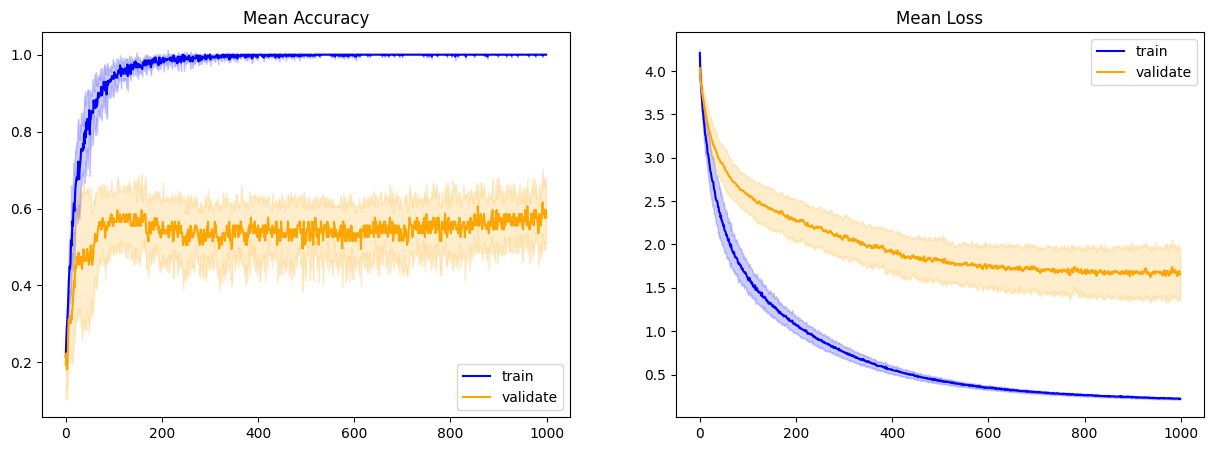

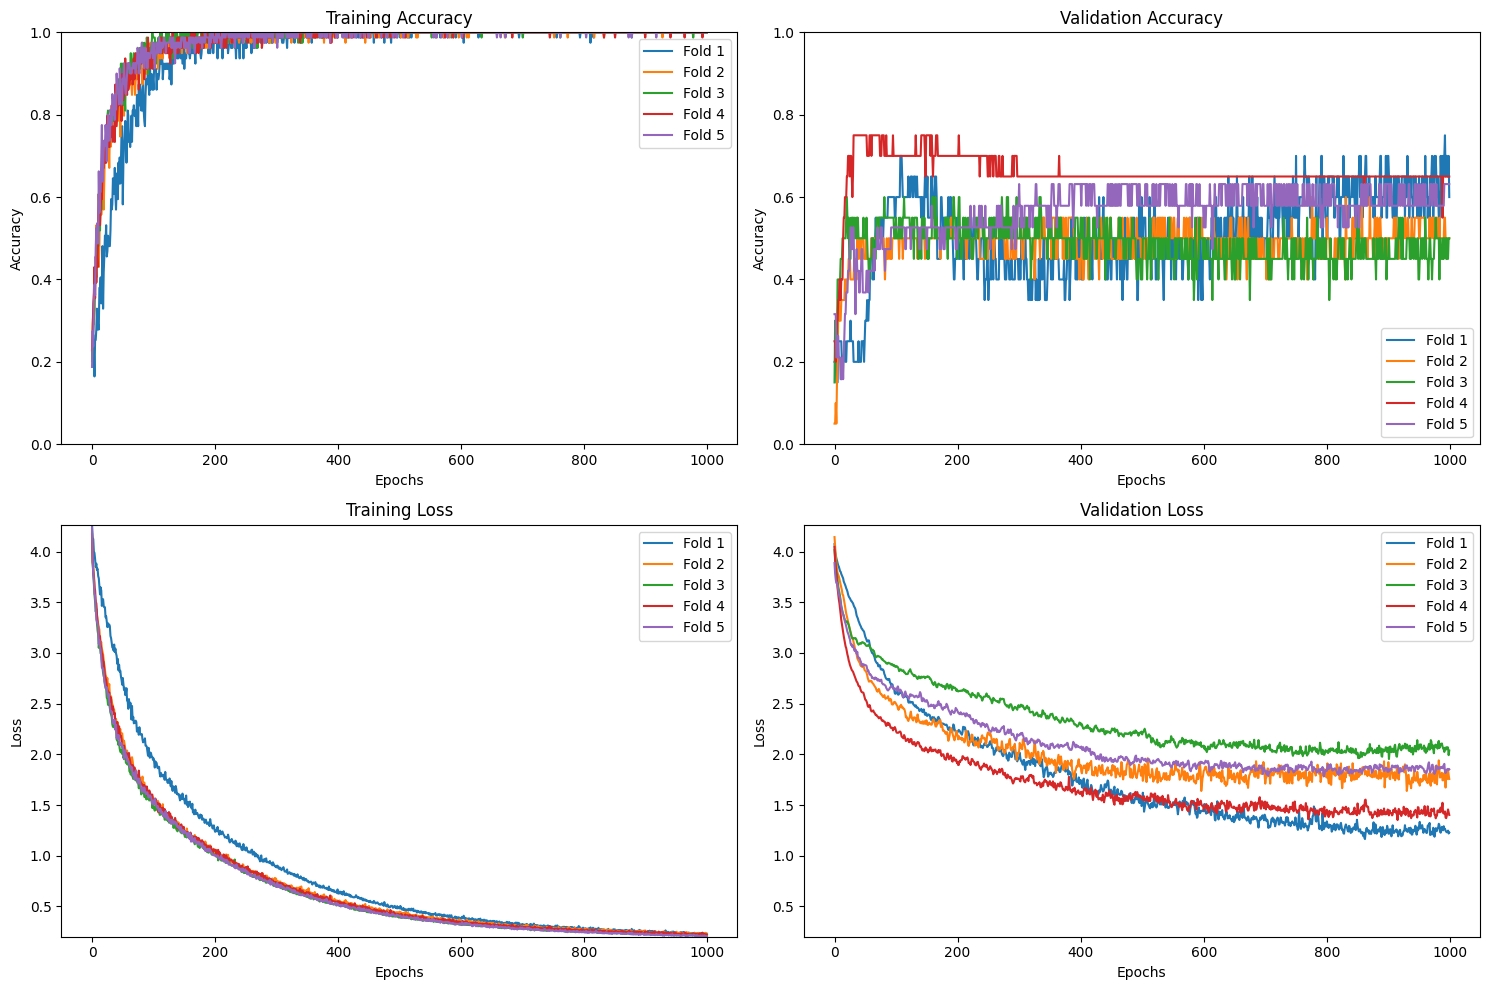

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
predicted classes:       [1 0 4 2 0 0 3 1 2 4 0 4 4 1 3 0 4 0 3]
true validation classes: [4 0 4 2 2 0 3 1 2 0 2 4 4 3 3 4 1 0 3]


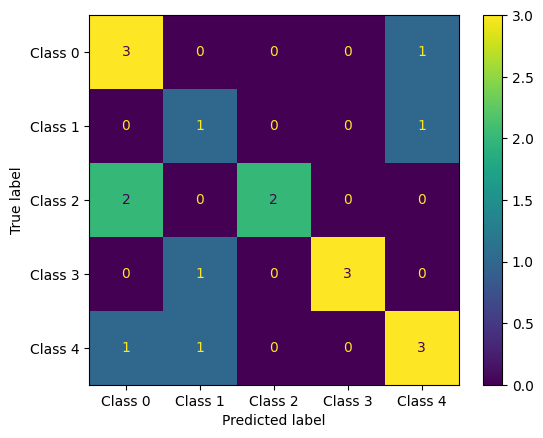

In [34]:
crossvalidate(df_train_val, model1, predictors,'pond_5', kf, epochs = 1000)

In [17]:
X_train = df_train_val[predictors].values
y_train = keras.utils.to_categorical(df_train_val['pond_5'].values)
X_test = df_test[predictors].values
y_test = keras.utils.to_categorical(df_test['pond_5'].values)

In [36]:
es = EarlyStopping(monitor='val_loss', patience=30)

In [37]:
reset_weights(model1)

In [31]:
history1=model1.fit(X_train, y_train, epochs = 1000, verbose = 0, shuffle = True, validation_data=(X_test, y_test), callbacks = [es])

# model evaluation
After model tuning on training / validation set its time we test it
we will start by extracting predicted classes from our predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6800 - loss: 0.9971
[0.9971379041671753, 0.6800000071525574]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted values: [1 2 2 1 3 1 0 1 2 4 1 3 2 0 4 1 3 0 4 2 0 1 1 3 2]
True values: [3 0 2 1 3 1 0 1 2 2 4 3 4 0 4 1 3 0 2 4 0 1 4 3 2]


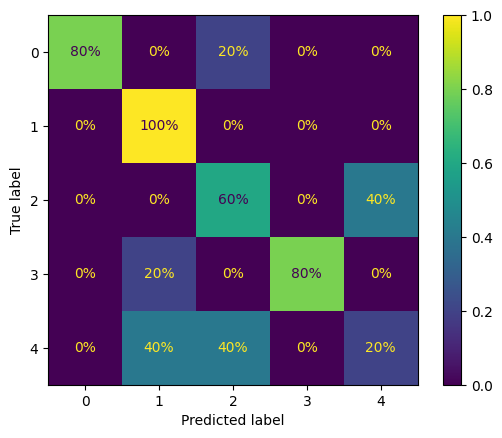

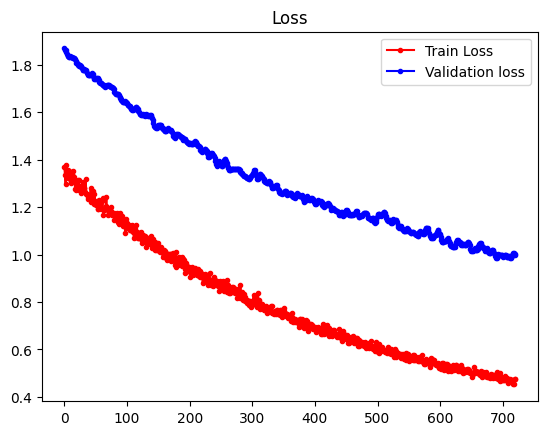

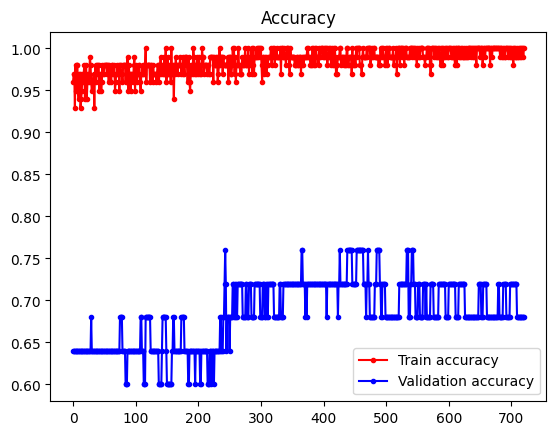

In [32]:
evaluate_model(model1, history1, X_test, y_test, acc_name = "Accuracy", loss_name = "Loss")

On those plots we can see that the results on test dataset are pretty bad which is interesting as crossvalidataion resuls seems to be quite better. Nevertheless test set accuracy barely excides random values. 

Explanation of pond coding

| number | setup | pond numbers | water supplementation | feed suplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

We will now perform class reduction based on biological asumptions, and we wil divide our set into 3 classes (controll, with feed supplementation, without feed supplementation)

# 3 classes
Here we will divide dataset into 3 classes 
0 - control (no water or feed suplementation)
1 - no feed suplementation 
2 - feed suplementation

In [38]:
y_train = keras.utils.to_categorical(df_train_val['pond_3'].values)
y_test = keras.utils.to_categorical(df_test['pond_3'].values)

In [39]:
df = df.copy()

## model building and compiling


In [48]:
model3 = keras.Sequential()
model3.add(keras.layers.Dense(128, input_shape=(len(predictors),), activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(64, activation ='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
#model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(16, activation ='relu',kernel_regularizer=keras.regularizers.l2(0.01)))

model3.add(keras.layers.Dense(3, activation ='softmax'))

model3.summary()

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 128)            │        16,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,603 (100.01 KB)

 Trainable params: 25,603 (100.01 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]
# worth trying same loss as metrics
optimizer = keras.optimizers.Adam(learning_rate = 0.001)

model3.compile(optimizer = optimizer, loss = loss, metrics=metrics)

## Crossvalidation


Number of classes: 3
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6000 - loss: 1.2718
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
predicted classes:       [1 1 0 1 1 0 0 1 1 1 1 0 2 2 0 1 1 1 1 1]
true validation classes: [1 1 1 2 2 0 1 1 1 1 1 2 2 2 0 2 2 1 1 2]
mean confidence score: 79.1521, sd confidence score: 180.0543
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5500 - loss: 1.7804
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 1 1 2 0]
true validation classes: [0 0 0 2 2 0 0 2 1 0 1 1 2 2 0 2 1 1 2 1]
mean confidence score: 927.1538, sd confidence score: 1878.3544
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8000 - loss: 1.0438
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [1 1 1 2 0 1 2 1 1 2 1 1 2 2 2 1 1 1 2 1]
true validation classes: [1 1 2 2 0 2 0 1 0 2 1 1 2 2 2 1 1 1 2 1]
mean confidence score: 62113.5944, sd confidence score

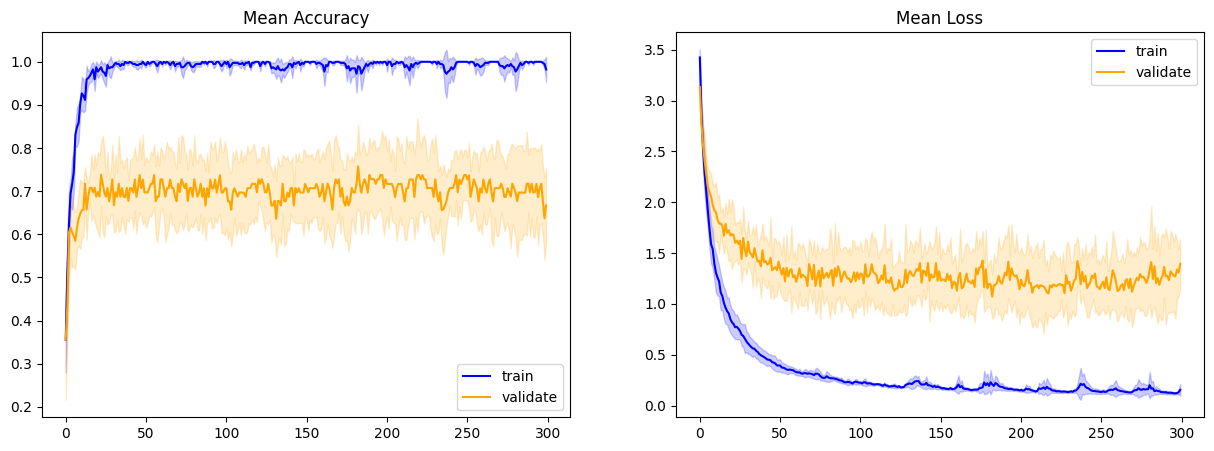

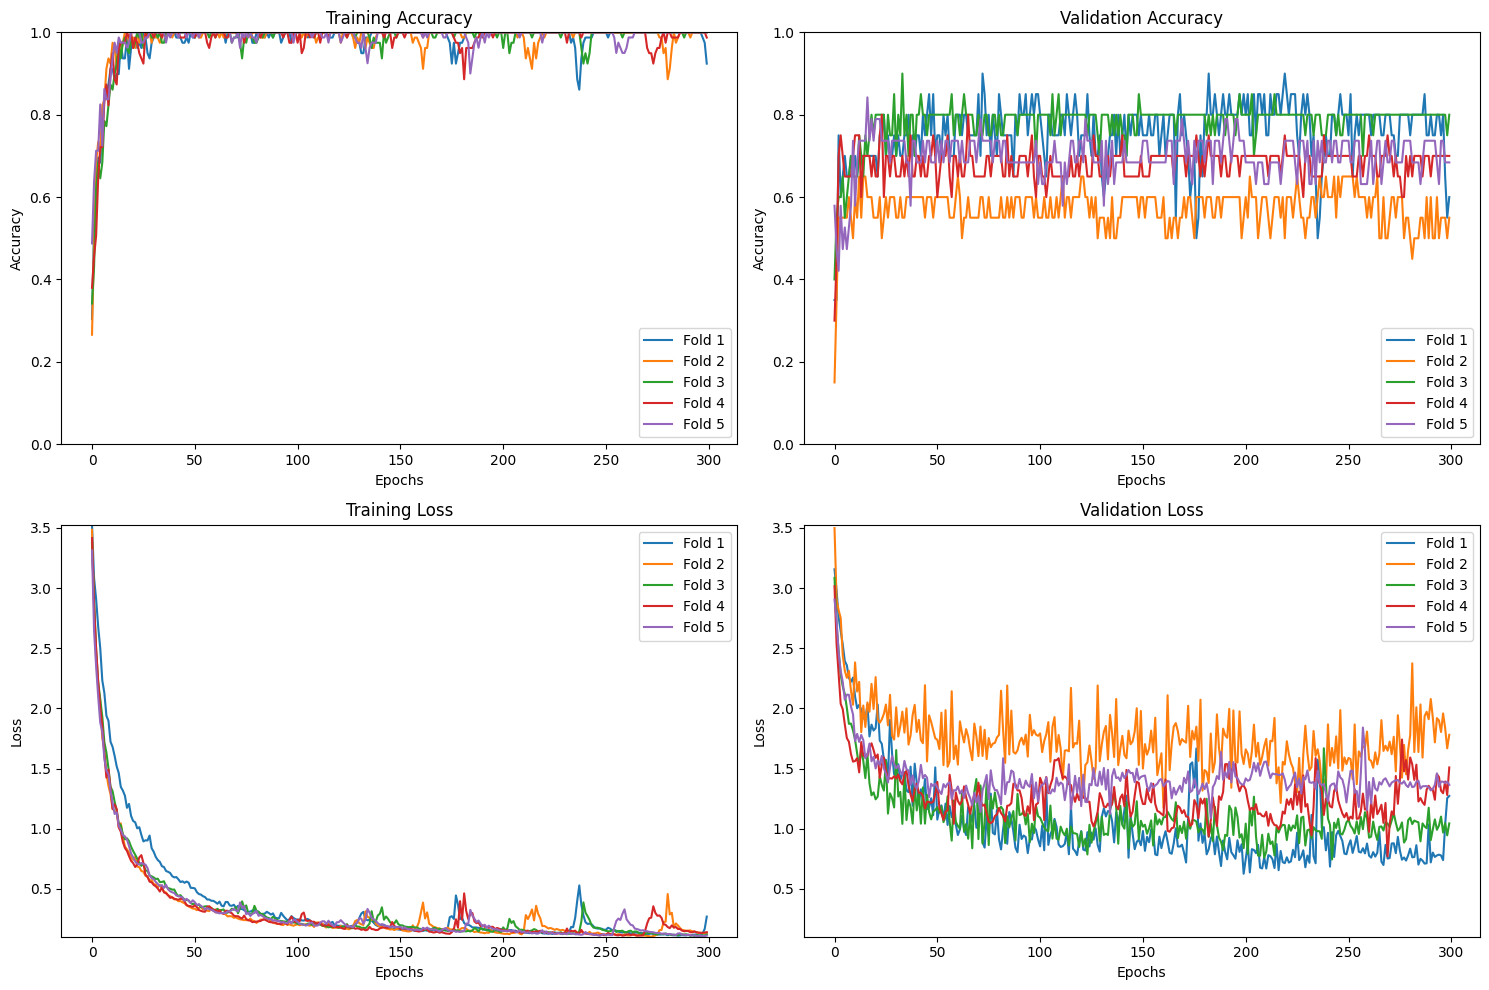

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
predicted classes:       [1 0 2 2 0 0 1 1 2 0 0 2 2 1 2 0 2 0 1]
true validation classes: [2 0 2 2 2 0 1 1 2 0 2 2 2 1 1 2 1 0 1]


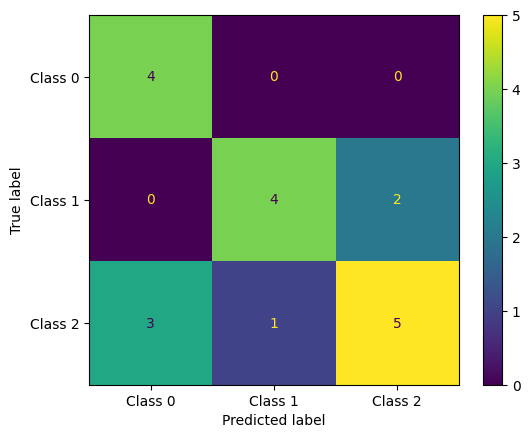

In [50]:
crossvalidate(df_train_val, model3, predictors, 'pond_3', kf)

In [54]:
reset_weights(model3)
es = EarlyStopping(monitor='val_loss', patience=100)
history3=model3.fit(X_train, y_train, epochs = 750, verbose = 0, shuffle = True, validation_data=(X_test, y_test), callbacks = [es])


## model evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8400 - loss: 0.4576
[0.4576163589954376, 0.8399999737739563]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted values: [1 2 2 1 1 1 0 1 2 2 1 2 2 0 2 1 1 0 2 2 0 1 1 1 2]
True values: [1 0 2 1 1 1 0 1 2 2 2 1 2 0 2 1 1 0 2 2 0 1 2 1 2]


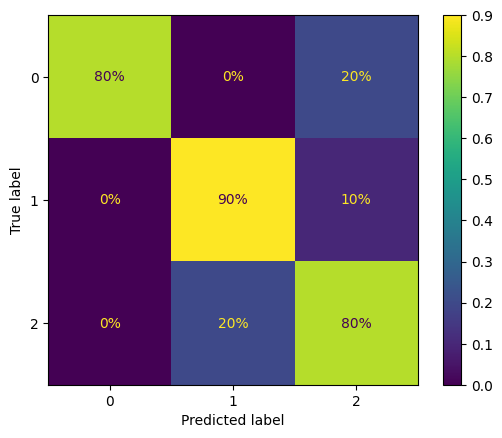

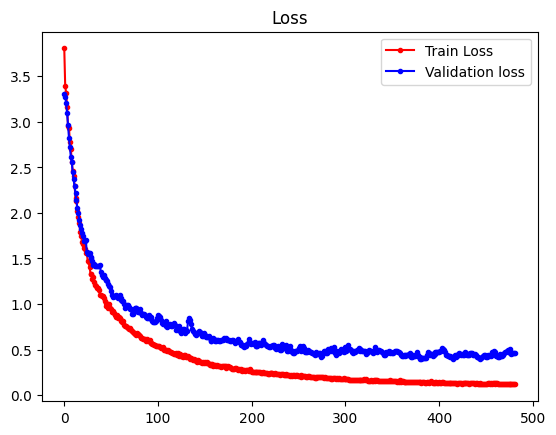

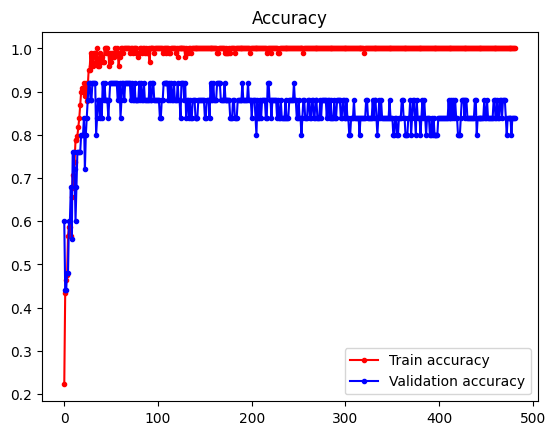

In [56]:
evaluate_model(history = history3, model = model3, X_test = X_test, y_test = y_test, acc_name = "Accuracy", loss_name = "Loss")

To remind ourselves what classes look like 

| number | class | pond numbers | feed suplementation |
|---|---|---|---|
|0|control(0) | 8,14,18,24,29|NO|
|1|1|12,16,19,23,26,9,13,17,20,27|NO|
|2|2| 10,21,28,30,32,11,15,22,25,31|EM|


As we can see this did help a bit, accuracy rised a little (we have to account for smaller number of classes) to around 0.7. Looking at confusion matrix the results for class 2 seems to be alright the problem is with model confusing clas 0 and 1, although it is understandable why model is confusing control with 1 class based on conclusions we draw before that feed suplementation has much more impact it is weird that model is misstaking 0 class as 2 class. We might try binary classification approach based only on feed suplementation without control group. 

# 2 classes
As we mentioned later here we will focus only on 2 classes 
- 0 - no feed classification 
- 1 - feed suplementation 

## model building and compiling

In [57]:
model2 = keras.Sequential()
model2.add(keras.layers.Dense(128, input_shape=(len(predictors),), activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
#model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='relu',kernel_regularizer=keras.regularizers.l2(0.01)))

model2.add(keras.layers.Dense(2, activation ='softmax'))

model2.summary()

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 128)            │        16,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,586 (99.95 KB)

 Trainable params: 25,586 (99.95 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]
# worth trying same loss as metrics
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

## Crossvalidation


Number of classes: 2
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8000 - loss: 0.4320
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
predicted classes:       [0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1]
true validation classes: [0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1]
mean confidence score: 579.9412, sd confidence score: 917.2334
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7000 - loss: 1.0922
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
predicted classes:       [0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 0 1 0]
true validation classes: [0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 0 0 1 0]
mean confidence score: 558.9343, sd confidence score: 1317.9406
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8000 - loss: 0.5302
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted classes:       [0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0]
true validation classes: [0 0 1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0]
mean confidence score: 4828.0401, sd confidence score

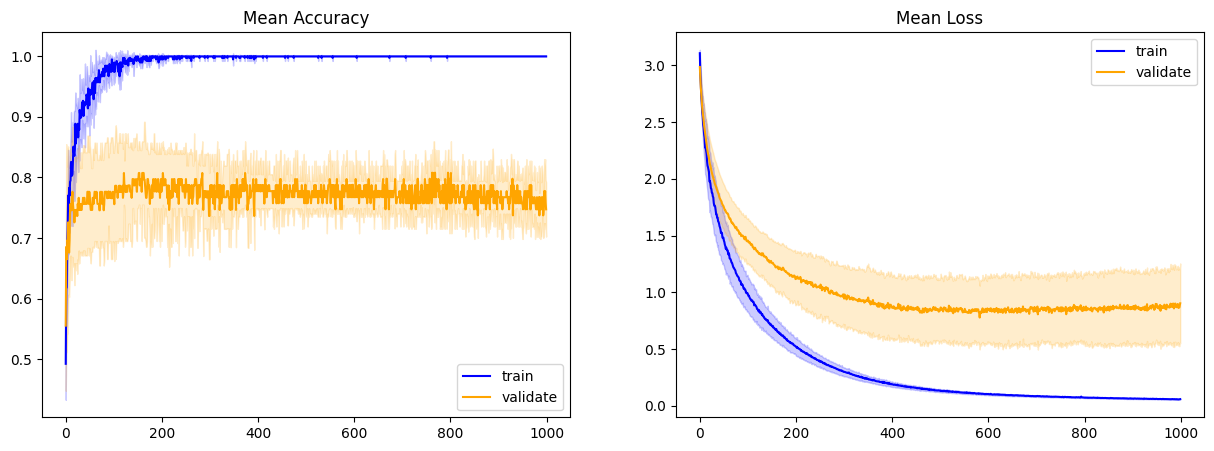

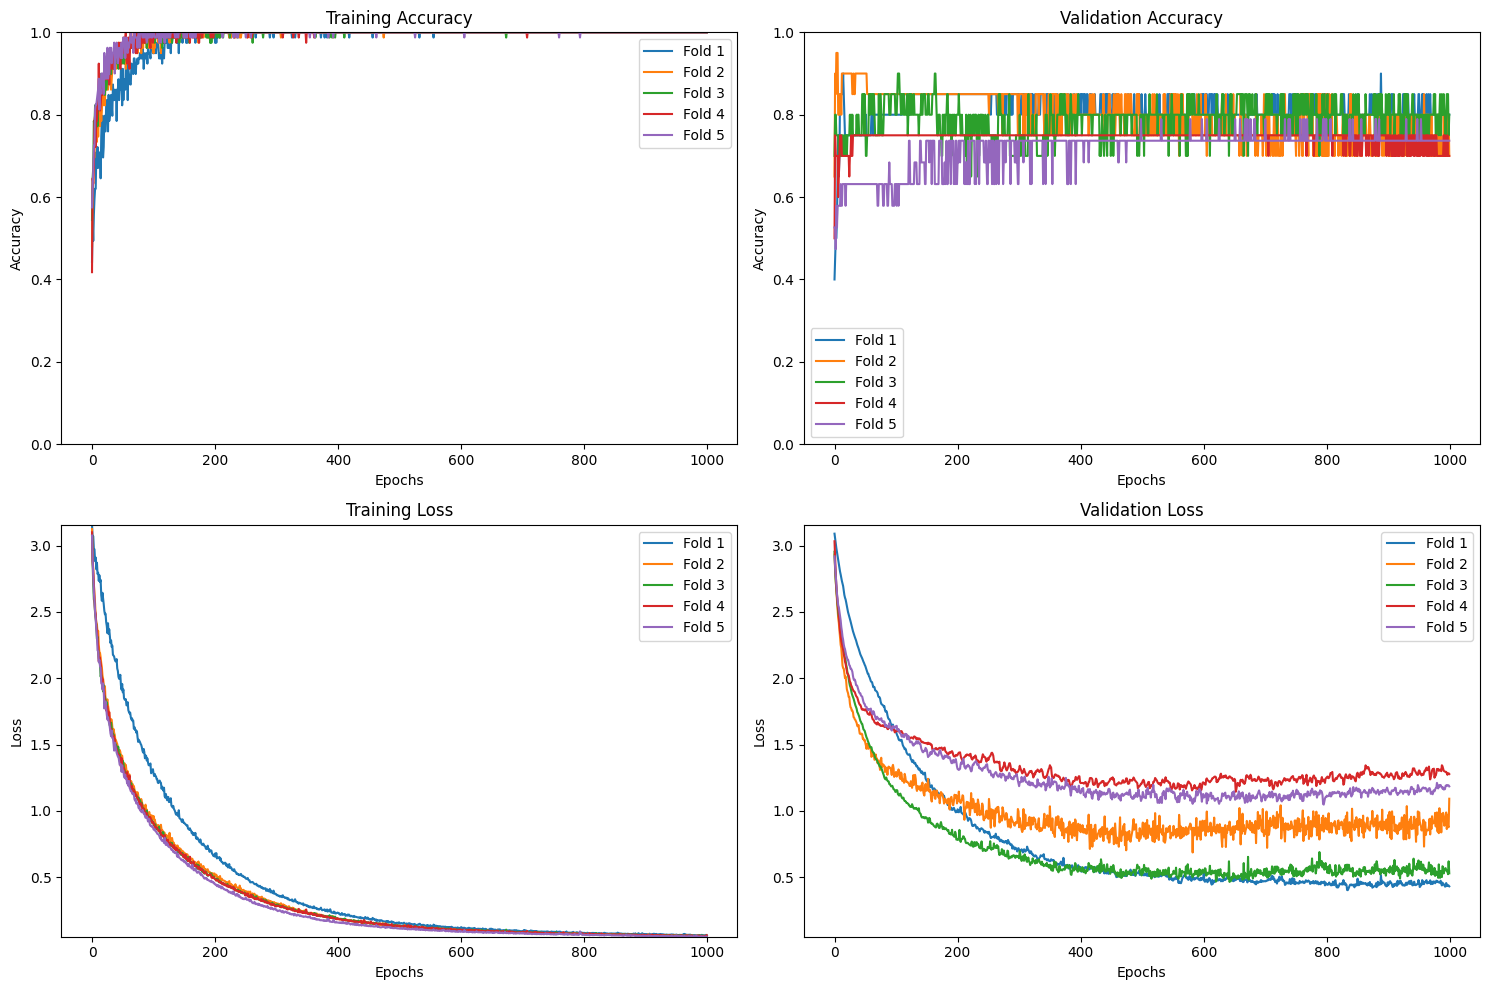

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
predicted classes:       [0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0]
true validation classes: [1 0 1 1 1 0 0 0 1 0 1 1 1 0 0 1 0 0 0]


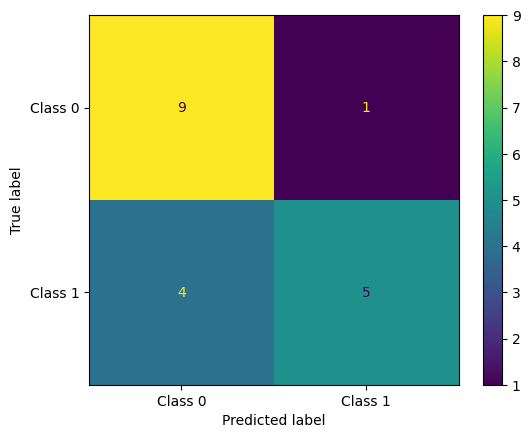

In [59]:
crossvalidate(df_train_val, model2, predictors, 'pond_2', kf, epochs=1000)

In [60]:
y_train = keras.utils.to_categorical(df_train_val['pond_2'].values)
y_test = keras.utils.to_categorical(df_test['pond_2'].values)

In [61]:
reset_weights(model2)
history2=model2.fit(X_train, y_train, epochs = 750, verbose = 0, shuffle = True, validation_data=(X_test, y_test), callbacks = [es])


## model evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8400 - loss: 1.6301
[1.6300815343856812, 0.8399999737739563]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted values: [0 1 1 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1]
True values: [0 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 1 0 1]


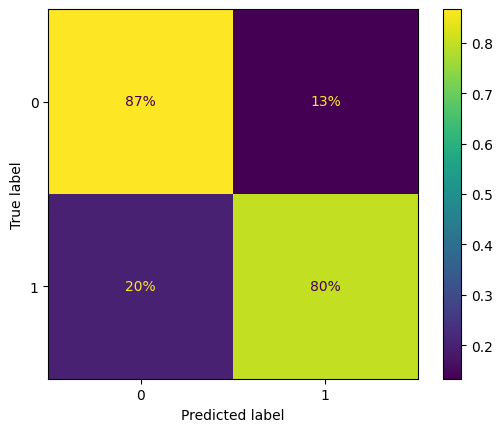

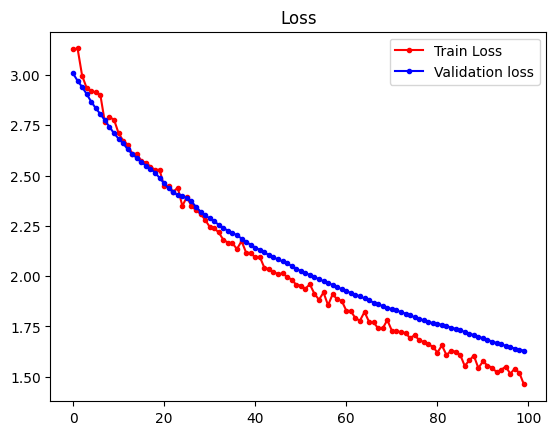

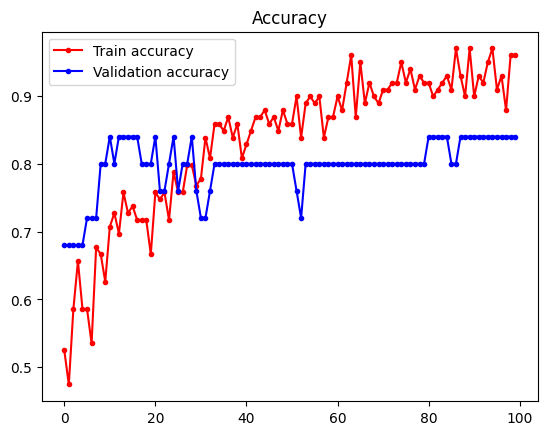

In [62]:

evaluate_model(history = history2, model = model2, X_test = X_test, y_test = y_test, acc_name = "Accuracy", loss_name = "Loss")

To remind ourselves what the current classes look like 

| number | class | pond numbers | feed suplementation |
|---|---|---|---|
|0|0|8,14,18,24,29,12,16,19,23,26,9,13,17,20,27|NO|
|1|1| 10,21,28,30,32,11,15,22,25,31|YES|

We can see quite good accuracy of 0.9 although we reducend number of classes this combined with probably more accurate biological classes made results quite good. We will now perform comparison with XGBoost classification tool to get the alternative results. 

# XGBoost comparison

## 5 classes

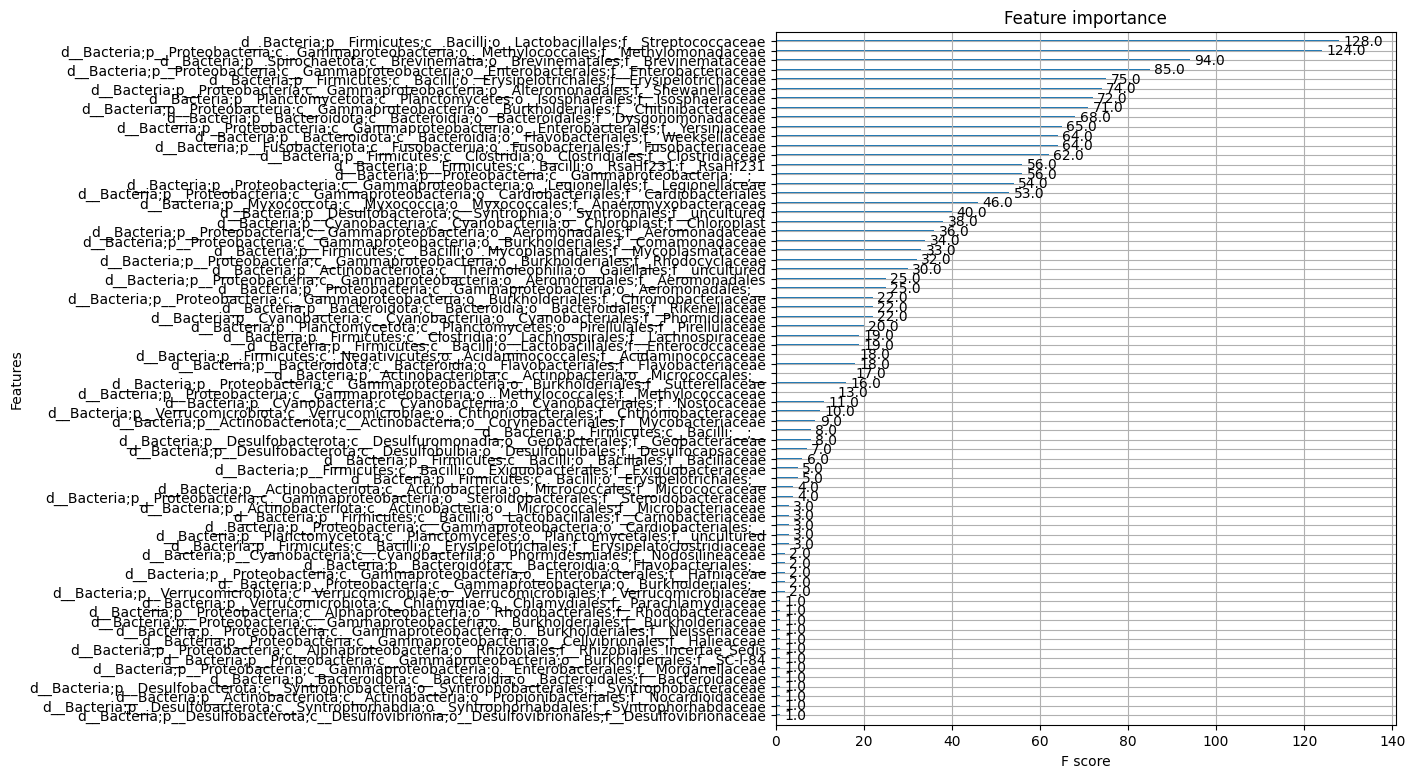

Accuracy0.56
true: [3 0 2 1 3 1 0 1 2 2 4 3 4 0 4 1 3 0 2 4 0 1 4 3 2]
predicted: [1. 0. 2. 1. 0. 4. 0. 1. 2. 1. 1. 3. 2. 0. 2. 1. 4. 0. 1. 4. 1. 1. 1. 3.
 2.]


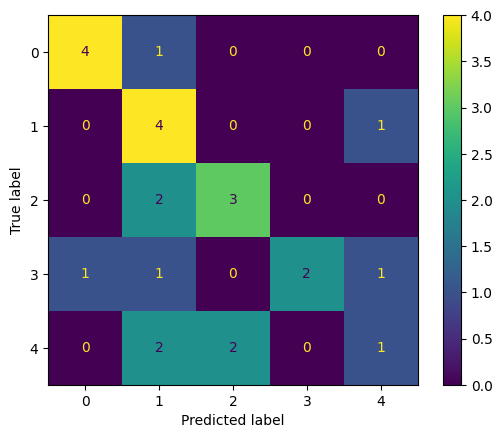

In [18]:
target = "pond_5"
dtrain = xgb.DMatrix(X_train, label=df_train_val[target].values, feature_names=predictors.to_list())  
dtest = xgb.DMatrix(X_test, label=df_test[target].values, feature_names=predictors.to_list())
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 3, # maximum deepth of the tree, used to controll complexity of the model
    'eta': 0.1,
    'seed': 111
}

x2 = xgb.train(params, dtrain, num_boost_round=100)

xgb_pred = x2.predict(dtest)
xgb_acc = accuracy_score(df_test[target].values, xgb_pred)

fig, ax = plt.subplots(figsize=(8, 9))  # Width: 8, Height: 12
xgb.plot_importance(x2, ax=ax)
plt.show()

print(f"Accuracy{xgb_acc}")

print(f"true: {df_test[target].values}")
print(f"predicted: {xgb_pred}")

cm = confusion_matrix(df_test[target].values, xgb_pred)
ConfusionMatrixDisplay(cm).plot()

## 3 Classes

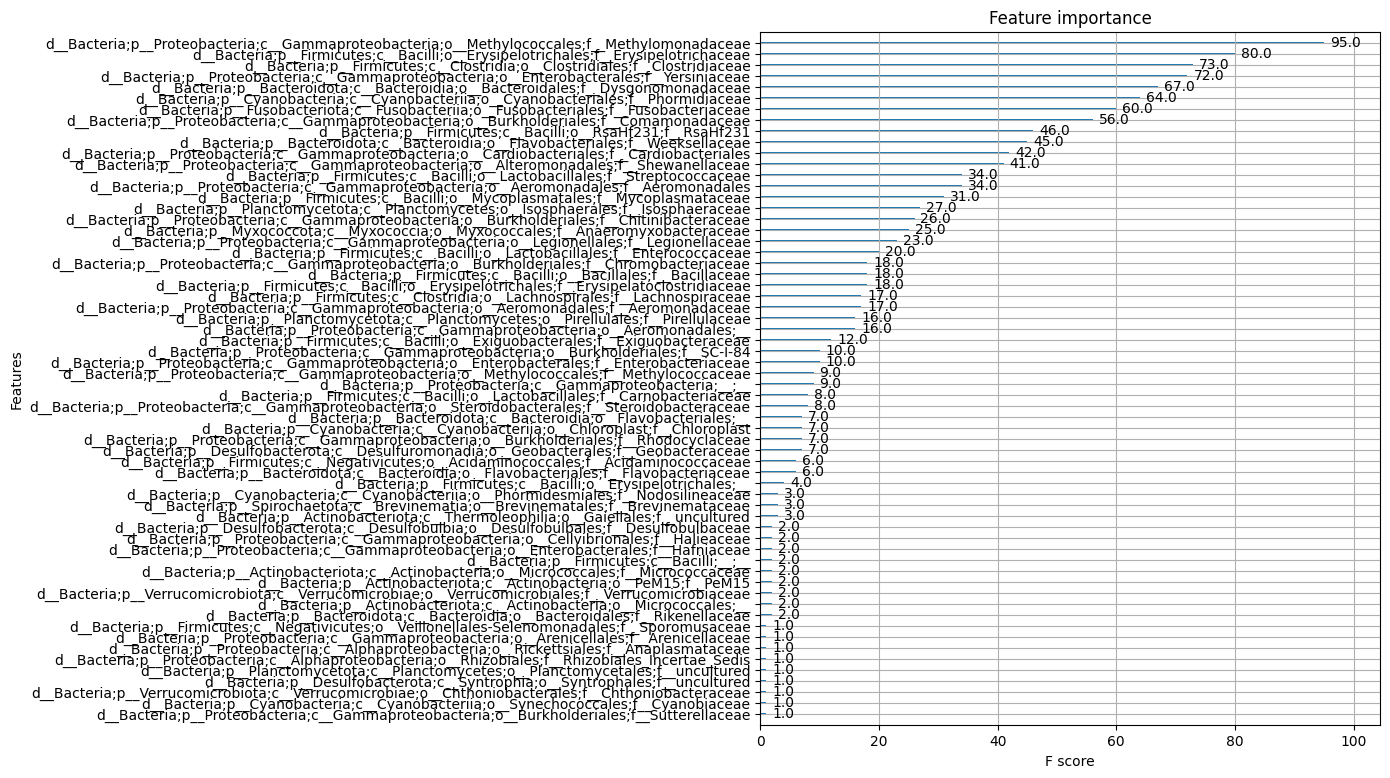

Accuracy0.64
true: [1 0 2 1 1 1 0 1 2 2 2 1 2 0 2 1 1 0 2 2 0 1 2 1 2]
predicted: [1. 0. 2. 1. 0. 1. 0. 1. 1. 0. 2. 2. 2. 1. 2. 1. 2. 1. 2. 2. 1. 1. 1. 1.
 2.]


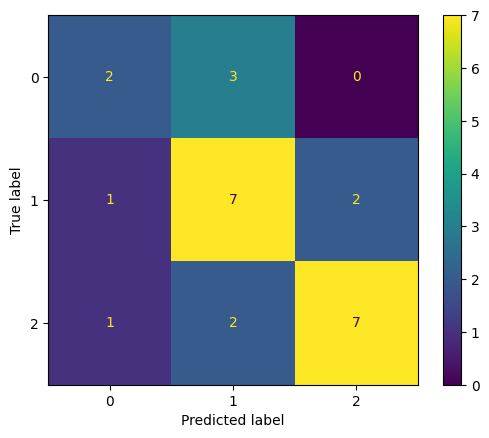

In [19]:
target = "pond_3"
dtrain = xgb.DMatrix(X_train, label=df_train_val[target].values, feature_names=predictors.to_list())  
dtest = xgb.DMatrix(X_test, label=df_test[target].values, feature_names=predictors.to_list())
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 3, 
    'eta': 0.1,
    'seed': 111
}

x2 = xgb.train(params, dtrain, num_boost_round=100)

xgb_pred = x2.predict(dtest)
xgb_acc = accuracy_score(df_test[target].values, xgb_pred)

fig, ax = plt.subplots(figsize=(8, 9))  
xgb.plot_importance(x2, ax=ax)
plt.show()
print(f"Accuracy{xgb_acc}")

print(f"true: {df_test[target].values}")
print(f"predicted: {xgb_pred}")

cm = confusion_matrix(df_test[target].values, xgb_pred)
ConfusionMatrixDisplay(cm).plot()

## 2 Classes

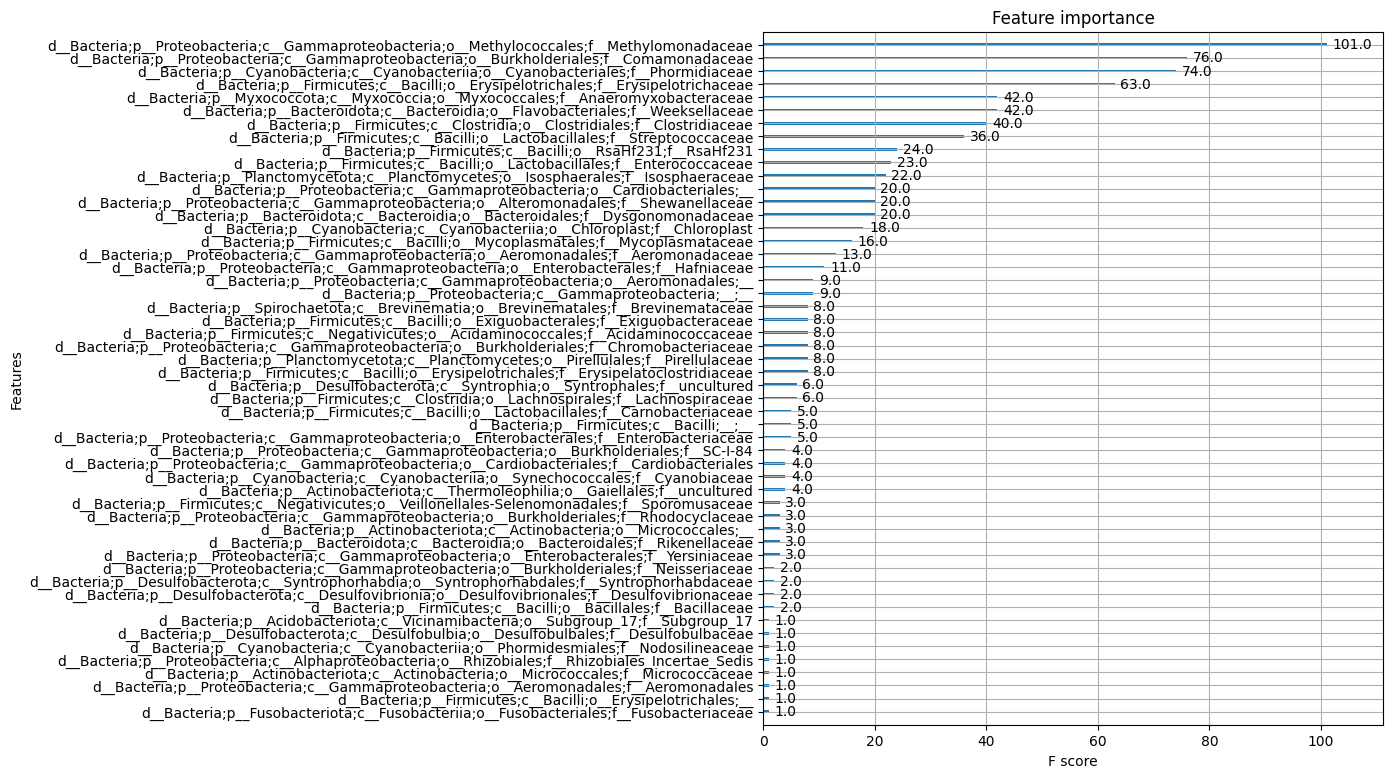

Accuracy0.84
true: [0 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 1 0 1]
predicted: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0.
 1.]


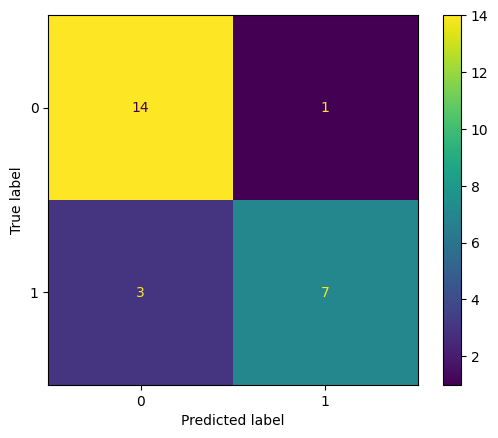

In [20]:
target = "pond_2"
dtrain = xgb.DMatrix(X_train, label=df_train_val[target].values, feature_names=predictors.to_list())  
dtest = xgb.DMatrix(X_test, label=df_test[target].values, feature_names=predictors.to_list())
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 3, 
    'eta': 0.1,
    'seed': 111
}

x2 = xgb.train(params, dtrain, num_boost_round=100)

xgb_pred = x2.predict(dtest)
xgb_acc = accuracy_score(df_test[target].values, xgb_pred)

fig, ax = plt.subplots(figsize=(8, 9))  
xgb.plot_importance(x2, ax=ax)
plt.show()

print(f"Accuracy{xgb_acc}")

print(f"true: {df_test[target].values}")
print(f"predicted: {xgb_pred}")

cm = confusion_matrix(df_test[target].values, xgb_pred)
ConfusionMatrixDisplay(cm).plot()

We can note that in general Xgboost results compare to those from neural networks altgouhh we have much better acuracy for 5 classes, and quite different confusion matrix for 3 and 2 classes.